# Homework 5

##### Data: chall.txt

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 13th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

<div class="answer-separator">
------------------------
</div>

In [3]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

## Question 1: We'll Always Have that Night Sampling in Monte Carlo

**Coding required**


Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of $X$:

$$h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}$$


Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:

**1.1.** Inverse Transform Sampling

In [49]:
# probability distribution we're trying to calculate
def p(x):
    if x >= 1 and x <= 3:
        return 1/12*(x-1)
    elif x > 3 and x <= 5:
        return -1/12*(x-5)
    elif x > 5 and x <= 7:
        return 1/6*(x-5)
    elif x > 7 and x <= 9:
        return -1/6*(x-9)
    else:
        0

In [50]:
# CDF of p
def cdf(x):
    if x >= 1 and x <= 3:
        return 1/24*(x-1)**2
    elif x > 3 and x <= 5:
        return -1/24*(x-5)**2 + 1/3
    elif x > 5 and x <= 7:
        return 1/12*(x-5)**2 +1/3
    elif x > 7 and x <= 9:
        return -1/12*(x-9)**2 +1
    else:
        0

In [51]:
# invert the CDF
def invCDF(r):
    if r >= 0 and r <= 1/6:
        return np.sqrt(24*r)+1
    elif r > 1/6 and r <= 1/3:
        return -np.sqrt(-24*(r-1/3))+5
    elif r > 1/3 and r <= 2/3:
        return np.sqrt(12*(r-1/3))+5
    elif r > 2/3 and r <= 1:
        return -np.sqrt(-12*(r-1))+9
    else:
        raise ValueError("r is outside the valid range")

In [71]:
# domain limits
xmin = 1 # the lower limit of our domain
xmax = 9 # the upper limit of our domain

# range limits
rmin = cdf(xmin)
rmax = cdf(xmax)

N = 100000 # the total of samples we wish to generate

# generate uniform samples in our range then invert the CDF
# to get samples of our target distribution
R = np.random.uniform(rmin, rmax, N)
X = np.array([invCDF(r) for r in R])

# calculate expected value
h = lambda x: 1/(3*np.sqrt(2)*np.pi)*np.exp(-1/18*(x - 5)**2)
print("The expected value according to inverse transform sampling is ",np.mean(h(X)))

The expected value is  0.05885488495863913


**1.2.** Rejection Sampling with a uniform proposal distribution (rejection sampling in a rectangular box with uniform probability of sampling any x)

In [95]:
N = 100000
exp_h_integrand = lambda x: h(x)*p(x)

In [96]:
X = np.random.uniform(1, 9, N)
y_max = 0.02
Y_sample = np.random.uniform(0,y_max,N)
exp_h_sample = np.array([exp_h_integrand(x) for x in X])
accepted = exp_h_sample > Y_sample
accepted_prop = sum(accepted)/len(accepted)
print("The expected value according to rejection sampling is ",accepted_prop*(9-1)*y_max)

The expected value according to rejection sampling is  0.058830400000000005


<div class="answer-separator">
------------------------
</div>

## Question 2: The Consequences of O-ring Failure can be Painful and Deadly

**Coding required**

In 1986, the space shuttle Challenger exploded during take off, killing the seven astronauts aboard. It is believed that the explosion was caused by the failure of an O-ring (a rubber ring that seals parts of the solid fuel rockets together), and that the failure was caused by the cold weather at the time of launch (31F).

In the file chall.txt, you will find temperature (in Fahrenheit) and failure data from 23 shuttle launches, where 1 stands for O-ring failure and 0 no failure. We assume that the observed temperatures are fixed and that, at temperature $t$, an O-ring fails with probability $f(\theta_{1}+\theta_{2}t)$ conditionally on $\Theta = (\theta_1, \theta_2)$.

$f(z)$ is defined to be the logistic function -- $f(z) = 1/(1 + \exp(-z))$ 

**2.1. Based on your own knowledge and experience, suggest a prior distribution for the regression parameters ($\theta_1, \theta_2$).  Make sure to explain your choice of prior.**

###### Let $\theta_3 = -\theta_1 / \theta_2$. Then $\theta_1+\theta_2 x = \theta_2(x-\theta_3)$

The question states that the failure is more likely at colder temperatures, so we know that $\theta_2$ is likely to be negative. We also know that there is probably a lot of noise in the relationship between temperature and O-ring failure, so we can say that $\theta_2$ is likely not very negative. I will pick a normal prior with mean -1 and standard deviation 5.

I do not know where this transition occurs, so I will choose a wide prior for $\theta_3$: a normal prior between centered at 50 and with standard deviation of 20.

**2.2. Produce 5000-10000 samples from the posterior distribution of $\Theta $ using rejection sampling, and plot them and their marginals. (This may take a while.)**

In [21]:
oring = pd.read_csv('./chall.txt',header = None, delim_whitespace=True)
oring.columns = ['temp', 'failure']
oring.head()

,temp,failure
0,66,0
1,70,1
2,69,0
3,68,0
4,67,0


In [25]:
def logprior(theta_2,theta_3):
    return (scipy.stats.norm.logpdf(theta_3, loc = 60, scale = 20) 
            + scipy.stats.norm.logpdf(theta_2, loc = -1, scale = 5))

def loglikelihood(theta_2,theta_3, temp = oring['temp'], label = oring['failure']):
    temp = np.array(temp)
    linearterm = theta_2*(temp - theta_3) 
    logits = 1/(1+np.exp(-linearterm))
    return np.sum([np.log(l) if label[idx] == 1 else np.log(1-l) for idx, l in enumerate(logits)])

def posterior(theta_2,theta_3):
    return np.exp(loglikelihood(theta_2,theta_3) + logprior(theta_2,theta_3))

In [26]:
# find maximum with grid
theta_2s = np.linspace(-5,0,100)
theta_3s = np.linspace(40,80,100)
print(max([posterior(t2,t3) for t2 in theta_2s for t3 in theta_3s]))

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


5.813253436377272e-08


In [32]:
required_num_samples = 5000
accepted_samples = []
while len(accepted_samples) < required_num_samples:
    theta_2 = np.random.uniform(-11,9)
    theta_3 = np.random.uniform(20,100)
    probs = np.random.uniform(0,1.0e-07)
    if probs < posterior(theta_2, theta_3):
        accepted_samples.append((theta_2, theta_3))
        if len(accepted_samples) % 100 == 0:
            print(len(accepted_samples))

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [33]:
theta_posterior = pd.DataFrame(accepted_samples)
theta_posterior.columns = ['theta_2','theta_3']
theta_posterior['theta_1'] = -theta_posterior['theta_2']*theta_posterior['theta_3']
theta_posterior.head()

,theta_2,theta_3,theta_1
0,-0.244530,60.317308,14.749395
1,-0.063615,56.154165,3.572274
2,-0.168119,67.848002,11.406566
3,-0.335525,66.952031,22.464071
4,-0.264192,65.749364,17.370461


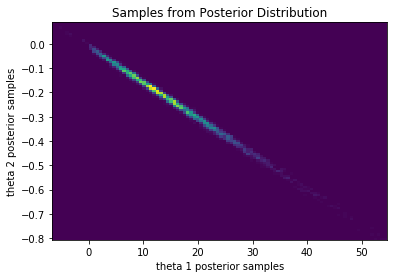

In [34]:
plt.hist2d(theta_posterior.theta_1,theta_posterior.theta_2,bins = 100)
plt.xlabel("theta 1 posterior samples")
plt.ylabel("theta 2 posterior samples")
plt.title("Samples from Posterior Distribution")
plt.show()

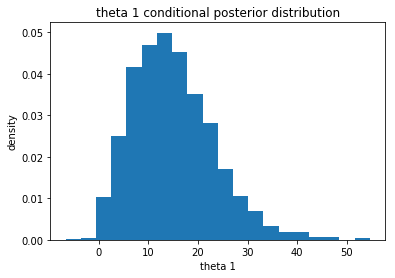

In [35]:
plt.hist(theta_posterior.theta_1,bins = 20, density = True)
plt.xlabel('theta 1')
plt.ylabel('density')
plt.title('theta 1 conditional posterior distribution')
plt.show()

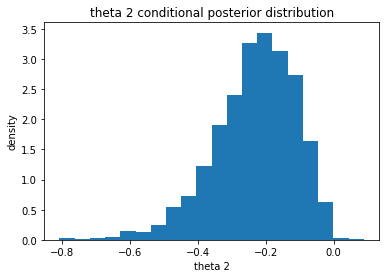

In [36]:
plt.hist(theta_posterior.theta_2, bins = 20, density = True)
plt.xlabel('theta 2')
plt.ylabel('density')
plt.title('theta 2 conditional posterior distribution')
plt.show()
plt.show()

**2.3.** Use the logit package in the `statsmodels` library to compute 68% confidence intervals on the $\theta$ parameters.  Compare those intervals with the 68% credible intervals from the posterior above. Overlay these on the above marginals plots. 

In [37]:
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Logit

model = Logit(oring.failure, add_constant(oring.temp)).fit()
theta_1_lower_conf = model.params[0]-model.bse[0]
theta_1_upper_conf = model.params[0]+model.bse[0]
theta_2_lower_conf = model.params[1]-model.bse[1]
theta_2_upper_conf = model.params[1]+model.bse[1]

Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 7


In [38]:
theta_1_lower_cred, theta_1_upper_cred = np.percentile(theta_posterior.theta_1,[16, 84])
theta_2_lower_cred, theta_2_upper_cred = np.percentile(theta_posterior.theta_2,[16, 84])

In [153]:
theta_1_lower_cred, theta_1_upper_cred

(6.927628537754204, 22.905245296917972)

In [154]:
theta_2_lower_cred, theta_2_upper_cred

(-0.34829214190754, -0.11430612442378575)

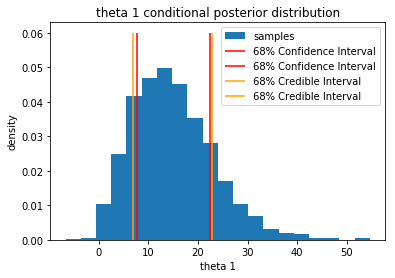

In [39]:
plt.hist(theta_posterior.theta_1,bins = 20, label = 'samples', density = True)
plt.vlines(theta_1_lower_conf, color = 'r', label = '68% Confidence Interval',ymin = 0,ymax = 0.06)
plt.vlines(theta_1_upper_conf, color = 'r', label = '68% Confidence Interval',ymin = 0,ymax = 0.06)
plt.vlines(theta_1_lower_cred, color = 'orange', label = '68% Credible Interval',ymin = 0,ymax = 0.06)
plt.vlines(theta_1_upper_cred, color = 'orange', label = '68% Credible Interval',ymin = 0,ymax = 0.06)
plt.xlabel('theta 1')
plt.ylabel('density')
plt.title('theta 1 conditional posterior distribution')
plt.legend()
plt.show()

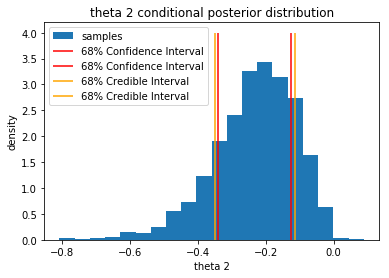

In [40]:
plt.hist(theta_posterior.theta_2,bins = 20, label = 'samples', density = True)
plt.vlines(theta_2_lower_conf, color = 'r', label = '68% Confidence Interval',ymin = 0,ymax = 4)
plt.vlines(theta_2_upper_conf, color = 'r', label = '68% Confidence Interval',ymin = 0,ymax = 4)
plt.vlines(theta_2_lower_cred, color = 'orange', label = '68% Credible Interval',ymin = 0,ymax = 4)
plt.vlines(theta_2_upper_cred, color = 'orange', label = '68% Credible Interval',ymin = 0,ymax = 4)
plt.xlabel('theta 2')
plt.ylabel('density')
plt.title('theta 2 conditional posterior distribution')
plt.legend()
plt.show()

**2.4.** Use the MLE values from `statsmodels` and the posterior mean from **2.2** at each temperature to plot the probability of failure in the frequentist and bayesian settings as a function of temperature. What do you see? 

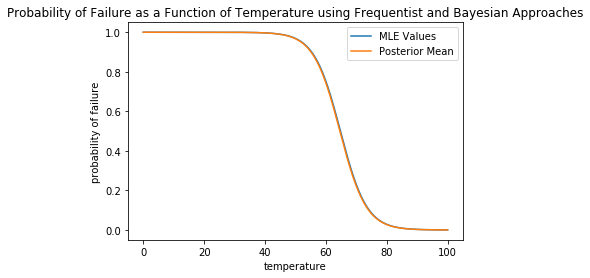

In [157]:
theta_1_mean = theta_posterior.theta_1.mean()
theta_2_mean = theta_posterior.theta_2.mean()
bayes_prob_failure = lambda x: 1/(1+np.exp(-(theta_1_mean+theta_2_mean*x)))

temp_lin = np.linspace(0,100,1000)
plt.plot(temp_lin,model.predict(add_constant(temp_lin)), label = 'MLE Values')
plt.plot(temp_lin,bayes_prob_failure(temp_lin), label = 'Posterior Mean')
plt.xlabel('temperature')
plt.ylabel('probability of failure')
plt.title('Probability of Failure as a Function of Temperature using Frequentist and Bayesian Approaches')
plt.legend()
plt.show()

The predictions from the two models are almost identical.

**2.5.** Compute the mean posterior probability for an O-ring failure at $t = 31^\circ F$. To do this you must calculate the posterior at $31^\circ F$ and take the mean of the samples obtained.

In [55]:
failure_31_post = 1/(1+np.exp(-(theta_posterior.theta_1+theta_posterior.theta_2*31)))
print("Mean posterior probability: ",np.mean(failure_31_post))

Mean posterior probability:  0.9701706853026671


**2.6.** You can instead obtain the probability from the posterior predictive. Use the posterior samples to obtain samples from the posterior predictive at $31^\circ F$ and calculate the fraction of failures.

In [159]:
failure_31_post_pred = np.random.binomial(n =1, p = failure_31_prob)
print("Proportion failure in posterior predictive: ",np.mean(failure_31_post_pred))

Proportion failure in posterior predictive:  0.9712


**2.7.** The day before a new launch, meteorologists predict that the temperature will be $T \sim N(68, 1)$ during take-off. Estimate the probability for an O-ring failure during this take-off. (You will calculate multiple predictives at different temperatures for this purpose).

In [64]:
temps = np.random.normal(loc = 68, scale = 1, size = 1000)
mean_posterior_prob_failure = []
for t in temps:
    failure_31_post = 1/(1+np.exp(-(theta_posterior.theta_1+theta_posterior.theta_2*t)))
    mean_posterior_prob_failure.append(np.mean(failure_31_post))
print("Probability of O-ring failure is ", np.mean(mean_posterior_prob_failure))

Probability of O-ring failure is  0.32678291588542663


<div class="answer-separator">
------------------------
</div>

## Question 3: Maximum Uniformity -- Frequentist Bootstraps and the Bayesian Posterior

**Coding required**

Recall in HW 3 Question 1 we attempted to explore an edge case in using non-parametric bootstrap to construct confidence intervals.  Let's revisit the setup of that problem.
Suppose you have $\{X_1, X_2, ... X_n\}$ datapoints such that $X_i$ are independently and identically drawn from a $Unif(0, \theta)$.  Consider the extreme order statistic Y = $X_{(n)}$ = max($X_1, X_2, ... X_n$).

**1.1. Derive (or possibly re-write from HW3) expressions for $F_Y(y\ \vert\ n, \theta)$ the CDF of Y and $f_Y(y\ |\ n, \theta)$ the pdf of Y.**

Let x be between 0 and $\theta$. We first derive the cdf.
$$
\begin{align}
F_Y(y \vert n, \theta) &= P(Y < y|n, \theta) \\
&= P(\text{max}(X_1, X_2, ... X_n) < y|n,\theta) \\
&= P(X_1 < x, X_2 < x, ..., X_n < y |n, \theta) \\
&= \prod_{i = 0}^{n}P(X_i < y|n, \theta) \\
&= \prod_{i = 0}^{n}\frac{y}{\theta} \\
&= \left(\frac{y}{\theta}\right)^n
\end{align}
$$
We take the derivate to find the pdf.

$$
\begin{align}
f_Y(Y|\theta) &= \frac{d}{dy}P(Y < y|n,\theta) \\
&= \frac{d}{dy} \left(\frac{y}{\theta}\right)^n \\
&= \frac{ny^{n-1}}{\theta^n}
\end{align}
$$

**1.2. In HW3 we had difficulty constructing confidence intervals to estimate $\theta$ with percentiles as normal so instead we introduced  pivot confidence intervals.  Let's reframe the problem so that we can use percentiles to construct our confidence intervals.  Define $Z \equiv n \cdot (\theta - Y)$ use elementary calculation to write an expression for $F_Z(z\ \vert\ n, \theta)$ the CDF of $Z$ and $f_Z(y\ |\ n, \theta)$ the pdf of Z.**

$$
\begin{align}
F_Z(z \vert n, \theta) &= P(Z < z \vert n, \theta) \\
&= P(n \cdot (\theta - Y) < z \vert n, \theta) \\
&= P(Y > \theta - z/n \vert n, \theta) \\ 
&= 1 - P(Y < \theta - z/n \vert n, \theta) \\ 
&= 1 - F_Y(\theta - z/n) \\
&= 1 - \left(\frac{\theta - z/n}{\theta}\right)^n \\
\end{align}
$$

We take the derivate to find the pdf.

$$
\begin{align}
f_Z(z|n,\theta) &= \frac{d}{dz}P(Z < z|n,\theta) \\
&= \frac{d}{dz} 1 - \left(\frac{\theta - z/n}{\theta}\right)^n \\
&= \frac{\left(1-\frac{z}{n\theta}\right)^{n-1}}{\theta}
\end{align}
$$


**1.3. What is the limiting distribution of Z (as $n \rightarrow \infty$)?  Plot that limiting distribution.**

$$
\begin{align}
\lim_{n\to\infty} f_Z(z|n,\theta) &= \lim_{n\to\infty} \frac{\left(1-\frac{z}{n\theta}\right)^{n-1}}{\theta} \\
&= \lim_{n\to\infty} \frac{\left(1-\frac{z}{n\theta}\right)^{n}}{\left(1-\frac{z}{n\theta}\right)\theta} \\
&= \frac{e^{-z/\theta}}{\theta}
\end{align}
$$

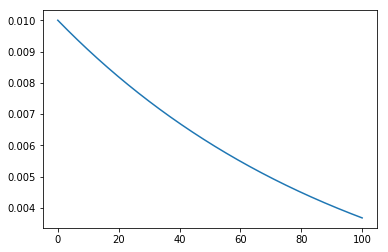

In [110]:
theta = 100
z = np.linspace(0,100,1000)
limit_Z = lambda z: np.exp(-z/theta)/theta
plt.plot(z,limit_Z(z))

**1.4. Use scipy/numpy to generate 100000 samples {$X_i$} from Unif(0,100) (i.e. let $\theta$ = 100).  Store them in Based on your data sample, what's $\hat{\theta}$ the empirical estimate for $\theta$.**

In [139]:
N = 100000
samples = np.random.uniform(0,100,N)
theta_hat = np.max(samples)
print("The empirical estimate for theta is ", theta_hat)

The empirical estimate for theta is  99.99879029533186


**1.5. Use non-parametric bootstrap to generate a sampling distribution of 10000 estimates for $Z$ by substituting $\hat{\theta}$ for $\theta$.  Plot a histogram of your sampling distribution.  Make sure to title and label the plot.  Use percentiles to construct the 10% and 68% bootstrap confidence intervals.  Plot them in your graph.**

**Hint:  Should the confidence intervals be symmetric around the estimate $\hat{\theta}$**?

In [112]:
num_of_bootstraps = 10000
bootstap_samples = np.random.choice(samples, replace=True, size = (num_of_bootstraps, N))
sampling_distribution = N*(theta_hat - np.max(bootstap_samples, axis = 1))

In [113]:
ten_CI_lower, ten_CI_upper = np.percentile(sampling_distribution, [45,55])
sixty_eight_CI_lower, sixty_eight_CI_upper = np.percentile(sampling_distribution, [16,84])

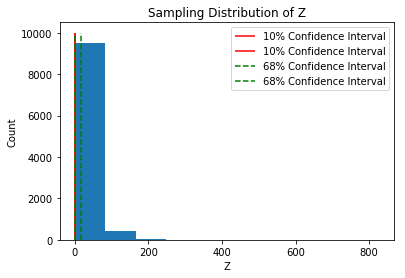

In [114]:
plt.hist(sampling_distribution)
plt.vlines(ten_CI_lower, color = 'r', label = '10% Confidence Interval',ymin = 0,ymax = 10000)
plt.vlines(ten_CI_upper, color = 'r', label = '10% Confidence Interval',ymin = 0,ymax = 10000)
plt.vlines(sixty_eight_CI_lower, color = 'g', linestyles = 'dashed',label = '68% Confidence Interval',ymin = 0,ymax = 10000)
plt.vlines(sixty_eight_CI_upper, color = 'g', linestyles= 'dashed',label = '68% Confidence Interval',ymin = 0,ymax = 10000)
plt.xlabel('Z')
plt.ylabel('Count')
plt.title('Sampling Distribution of Z')
plt.legend()
plt.show()

**1.6. Make an argument that we can construct a bootstrap confidence interval that always mismatches the limiting distribution.**

As the size of our bootstrap samples get larger, the chance of having the maximum value from the original dataset in our boostrap sample increases. The probability of having the maximum value in our bootstrap sample is $1-(1-1/n)^n$. If we let n go to infinity, 

$$
\lim_{n \to \infty} 1-(1-1/n)^n = \frac{e-1}{e}
$$

This means that the probability that $p(Z = 0) = \frac{e-1}{e}$, which is different from the pdf $f(0) = \frac{1}{\theta}$. Hence the confidence interval will mismatch the limiting distribution.

**1.8. Let's switch to being Bayesian.  In 1.1 we came up with an expression for the likelihood $f_Y(y\ |\ n, \theta)$.  Use the [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution) to construct a prior for $\theta$.  What are some reasonable values to use for the scale and shape?**

Since we don't know anything about $\theta$, we define the prior to have scale $\beta = 1$ and shape $\alpha = 0.1$. This assumes that theta is greater than 1.

**1.9. Write down an expression for the posterior distribution $f_Y(\theta\ |\ n, y)$**

$$
\begin{align}
f_Y(\theta\ |y,n) &= \frac{f(y, n\vert\theta)f(\theta)}{\int_1^\infty f(y, n\vert\theta)f(\theta)d\theta} \\
&= \frac{\frac{ny^{n-1}}{\theta^n}\frac{\alpha \beta^\alpha}{\theta^{\alpha+1}}}{\int_y^\infty \frac{ny^{n-1}}{\theta^n}\frac{\alpha \beta^\alpha}{\theta^{\alpha+1}}d\theta} \\
&= \frac{\theta^{-(n+\alpha+1)}}{\int_y^\infty \theta^{-(n+\alpha+1)} d\theta} \\
&= \frac{(n+\alpha)\theta^{-(n+\alpha+1)}}{y^{-(n+\alpha)}}\\
&= \frac{(n+\alpha)y^{n+\alpha}}{\theta^{n+\alpha+1}}\\
&= \text{pareto}(n+0.1,y)
\end{align}
$$

**1.10. Draw 10000 posterior samples and plot a histogram of the posterior distribution.  Use percentiles to construct the 68% HPD.  Plot the posterior distribution and mark the HPD on your plot.**

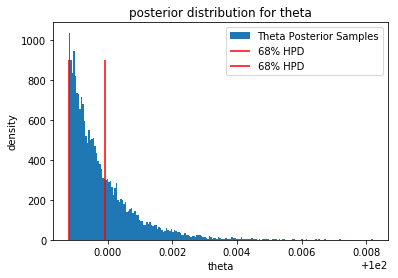

In [148]:
a = 0.1
a_post, b_post = N+a, theta_hat  # shape and mode
s = (np.random.pareto(a_post, 10000) + 1) * b_post
HPD_lower, HPD_upper = np.percentile(s, [0,68])
plt.hist(s, density = True, bins = 200, label = 'Theta Posterior Samples')
plt.vlines(HPD_lower, color = 'r', label = '68% HPD',ymin = 0,ymax = 900)
plt.vlines(HPD_upper, color = 'r', label = '68% HPD',ymin = 0,ymax = 900)
plt.legend()
plt.xlabel('theta')
plt.ylabel('density')
plt.title('posterior distribution for theta')
plt.show()

**1.11.** How does th 68% HPD compare with the confidence interval generated from bootstrapping?  Why doesn't the bayesian interval construction suffer the same concerns you noted in 1.6

The frequentist approach treats our parameter estimates as fixed and tries to model the uncertainty induced by the data generating process. Since we are dealing with the edge of our distribution, it is difficult to model uncertainty in the data generating process.

The Bayesian approach, alternatively, treats the data as fixed and accounts for uncertainty in our parameters.  In the Bayesian approach, it doesn't matter that we are dealing with the edge of our distribution because our data is assumed to be fixed - instead, we transfer the uncertainty to our parameters which implicitly handle our "data point" being at the edge of our sample.

<div class="answer-separator">
------------------------
</div>